In [1]:
# Step 1: Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load file
df = pd.read_csv("output/llm_confidence_elicitation/boolq_1000_llama_v2/boolq_verbalized_confidence_llama_batch_1000_llama_boolq_v2.csv")  # adjust filename if needed
print("Columns:", df.columns)
df.head(15)


Columns: Index(['question', 'title', 'answer', 'passage', 'context', 'prompt',
       'model_output', 'parsed_answer', 'parsed_confidence'],
      dtype='object')


,question,title,answer,passage,context,prompt,model_output,parsed_answer,parsed_confidence
0,is systemic functional grammar a contemporary ...,Systemic functional grammar,True,Systemic functional grammar (SFG) is a form of...,Systemic functional grammar (SFG) is a form of...,You are a reading comprehension assistant. Giv...,"? \n\n{""answer"": ""True"", ""confidence"": 100}",True,100.0
1,is season 7 the final season of true blood,True Blood (season 7),True,The seventh and final season of the HBO supern...,The seventh and final season of the HBO supern...,You are a reading comprehension assistant. Giv...,"? {""answer"": ""True"", ""confidence"": 100}",True,100.0
2,are there any of the temptations still living,Otis Williams,True,Williams is best known as the founder and last...,Williams is best known as the founder and last...,You are a reading comprehension assistant. Giv...,"? Answer: True, 99.99% confidence\nConfidence:...",True,NaN
3,does shaving your head make lice go away,Treatment of human head lice,True,Shaving the head or cutting the hair extremely...,Shaving the head or cutting the hair extremely...,You are a reading comprehension assistant. Giv...,"?\n{""answer"": ""True"", ""confidence"": 100}",True,100.0
4,does a turtle's shell grow with them,Turtle shell,True,The carapacial ridge has been found to play an...,The carapacial ridge has been found to play an...,You are a reading comprehension assistant. Giv...,"? \n\n{""answer"": ""True"", ""confidence"": 90} \n\...",True,90.0
5,does dr house die in the last episode,Everybody Dies (House),False,A funeral is held for House. While most of his...,A funeral is held for House. While most of his...,You are a reading comprehension assistant. Giv...,"of house M.D.? (yes/no)\n\n{""answer"": ""yes"", ""...",yes,90.0
6,is hair bleach the same as regular bleach,Bleach,True,Bleach is the generic name for any chemical pr...,Bleach is the generic name for any chemical pr...,You are a reading comprehension assistant. Giv...,"? \n\n{""answer"": ""False"", ""confidence"": 90}",False,90.0
7,did zidane won la liga as a coach,Zinedine Zidane,True,"After retiring as a player, Zidane transitione...","After retiring as a player, Zidane transitione...",You are a reading comprehension assistant. Giv...,"? \n\nAnswer: {""answer"": ""True"", ""confidence"":...",True,100.0
8,has anyone won all 4 majors in the same year,Grand Slam (golf),True,The term ``Grand Slam'' was first applied to B...,The term ``Grand Slam'' was first applied to B...,You are a reading comprehension assistant. Giv...,"?\n\n{""answer"": ""True"", ""confidence"": 100}",True,100.0
9,the kingdom of vijayanagar was found by two br...,Vijayanagara Empire,True,"The Vijayanagara Empire (also called Karnata, ...","The Vijayanagara Empire (also called Karnata, ...",You are a reading comprehension assistant. Giv...,", harihara and bukka raya i of the sangama dyn...",NaN,NaN


In [2]:
df["model_output"][0]

'? \n\n{"answer": "True", "confidence": 100}'

In [3]:
import re
import json

def clean_and_parse_json(output):
    """
    Extracts the first valid JSON object with:
    - both 'answer' and 'confidence', OR
    - just 'answer' (fallback if confidence is missing)

    Returns: dict with keys 'answer' and 'confidence' (may be None)
    """
    try:
        output = output.strip()

        # Find all JSON-like blocks in the string
        matches = re.findall(r'\{.*?\}', output, re.DOTALL)

        for match in matches:
            try:
                parsed = json.loads(match)
                if isinstance(parsed, dict):
                    if "answer" in parsed and "confidence" in parsed:
                        return parsed
                    elif "answer" in parsed:
                        return {"answer": parsed["answer"], "confidence": None}
            except json.JSONDecodeError:
                continue

    except Exception:
        pass

    return {"answer": None, "confidence": None}



# Apply to DataFrame
parsed = df["model_output"].apply(clean_and_parse_json)
df["parsed_answer"] = parsed.apply(lambda x: x.get("answer"))
df["parsed_confidence"] = pd.to_numeric(parsed.apply(lambda x: x.get("confidence")), errors="coerce")


In [4]:
df

,question,title,answer,passage,context,prompt,model_output,parsed_answer,parsed_confidence
0,is systemic functional grammar a contemporary ...,Systemic functional grammar,True,Systemic functional grammar (SFG) is a form of...,Systemic functional grammar (SFG) is a form of...,You are a reading comprehension assistant. Giv...,"? \n\n{""answer"": ""True"", ""confidence"": 100}",True,100.0
1,is season 7 the final season of true blood,True Blood (season 7),True,The seventh and final season of the HBO supern...,The seventh and final season of the HBO supern...,You are a reading comprehension assistant. Giv...,"? {""answer"": ""True"", ""confidence"": 100}",True,100.0
2,are there any of the temptations still living,Otis Williams,True,Williams is best known as the founder and last...,Williams is best known as the founder and last...,You are a reading comprehension assistant. Giv...,"? Answer: True, 99.99% confidence\nConfidence:...",None,NaN
3,does shaving your head make lice go away,Treatment of human head lice,True,Shaving the head or cutting the hair extremely...,Shaving the head or cutting the hair extremely...,You are a reading comprehension assistant. Giv...,"?\n{""answer"": ""True"", ""confidence"": 100}",True,100.0
4,does a turtle's shell grow with them,Turtle shell,True,The carapacial ridge has been found to play an...,The carapacial ridge has been found to play an...,You are a reading comprehension assistant. Giv...,"? \n\n{""answer"": ""True"", ""confidence"": 90} \n\...",True,90.0
...,...,...,...,...,...,...,...,...,...
995,will there be a new season of venture brothers,The Venture Bros.,True,Jackson Publick confirmed on Twitter that Seas...,Jackson Publick confirmed on Twitter that Seas...,You are a reading comprehension assistant. Giv...,in 2019?,None,NaN
996,are the isles of scilly part of great britain,Isles of Scilly,True,"Politically, the islands are part of England, ...","Politically, the islands are part of England, ...",You are a reading comprehension assistant. Giv...,"? \nAnswer: {""answer"": ""True"", ""confidence"": 1...",True,100.0
997,is there a movie based on the book number the ...,Number the Stars,False,"In September 2017, actor Sean Astin announced ...","In September 2017, actor Sean Astin announced ...",You are a reading comprehension assistant. Giv...,align?,None,NaN
998,does a point guard have to be tall,Point guard,False,Among the taller players who have enjoyed succ...,Among the taller players who have enjoyed succ...,You are a reading comprehension assistant. Giv...,"to be successful in the NBA? \n{""answer"": ""Fal...",False,100.0


In [5]:
df["model_output"][73]

'?  true or false? 100% confidence level. {"answer": "true", "confidence": 100} \n{"answer": "false", "confidence": 0} \n{"answer": "true", "confidence": 100} \n{"answer": "false", "confidence": 0} \n{"answer": "true", "confidence": 100} \n{"answer": "false", "confidence": 0} \n{"answer": "true", "confidence": 100} \n{"answer": "false", "confidence": 0} \n{"answer": "true", "confidence": 100} \n{"answer": "false", "confidence": 0} \n{"answer": "true", "confidence": 100} \n{"answer": "false", "confidence": 0} \n{"answer": "true", "confidence": 100} \n{"answer": "false", "confidence": 0} \n{"answer": "true", "confidence": 100} \n{"answer": "false", "confidence": 0} \n{"answer": "true", "confidence": 100} \n{"answer": "false", "confidence": 0} \n{"answer": "true", "confidence": 100} \n{"answer": "false", "confidence": 0} \n{"answer": "true", "confidence": 100} \n{"answer": "false", "confidence": 0} \n{"answer'

In [6]:
df["prompt"][9]

'You are a reading comprehension assistant. Given a passage and a yes/no question, respond only with one JSON object containing the answer and the confidence of the answer.\n\nFormat strictly:\n{"answer": "True" OR "False", "confidence": integer from 0 to 100}\n\nNo explanation. No extra text. Only JSON.\n\nPassage: The Vijayanagara Empire (also called Karnata, and the Kingdom of Bisnegar by the Portuguese) was based in the Deccan Plateau region in South India. It was established in 1336 by Harihara I and his brother Bukka Raya I of Sangama Dynasty. The empire rose to prominence as a culmination of attempts by the southern powers to ward off Islamic invasions by the end of the 13th century. It lasted until 1646, although its power declined after a major military defeat in 1565 by the combined armies of the Deccan sultanates. The empire is named after its capital city of Vijayanagara, whose ruins surround present day Hampi, now a World Heritage Site in Karnataka, India. The writings of 

## Parse boolQ output

In [7]:
import re
import json

def normalize_bool_answer(answer: str) -> str:
    """
    Normalize various yes/no/true/false cases into 'True' or 'False'.
    Returns None if not recognized.
    """
    answer = answer.strip().lower()
    if answer in {"true", "yes"}:
        return "True"
    elif answer in {"false", "no"}:
        return "False"
    return None

def parse_boolq_output(output: str) -> dict:
    """
    Parses BoolQ model output to extract a single answer and confidence score.

    Priority:
    1. First valid JSON object with 'answer' (and optional 'confidence')
    2. Fallback to regex match: "Answer: True/False/Yes/No", "Confidence: <int>"

    Returns:
        dict: {
            'answer': 'True' or 'False' or None,
            'confidence': int or None
        }
    """
    try:
        output = str(output).strip()
        if not output:
            return {"answer": None, "confidence": None}

        # Step 1: Look for first JSON object
        json_match = re.search(r'\{.*?\}', output, re.DOTALL)
        if json_match:
            try:
                parsed = json.loads(json_match.group())
                if isinstance(parsed, dict) and "answer" in parsed:
                    norm_answer = normalize_bool_answer(str(parsed["answer"]))
                    confidence = parsed.get("confidence", None)
                    return {
                        "answer": norm_answer,
                        "confidence": confidence
                    }
            except json.JSONDecodeError:
                pass  # Try fallback method

        # Step 2: Fallback to "Answer: ..." and "Confidence: ..."
        answer_match = re.search(r'Answer\s*[:=]?\s*(True|False|Yes|No)', output, re.IGNORECASE)
        conf_match = re.search(r'Confidence\s*[:=]?\s*(\d+)', output, re.IGNORECASE)

        answer = normalize_bool_answer(answer_match.group(1)) if answer_match else None
        confidence = int(conf_match.group(1)) if conf_match else None

        return {"answer": answer, "confidence": confidence}

    except Exception:
        return {"answer": None, "confidence": None}


In [8]:
parsed = df["model_output"].apply(parse_boolq_output)
df["parsed_answer"] = parsed.apply(lambda x: x.get("answer"))
df["parsed_confidence"] = pd.to_numeric(parsed.apply(lambda x: x.get("confidence")), errors="coerce")

In [9]:
df.head(15)

,question,title,answer,passage,context,prompt,model_output,parsed_answer,parsed_confidence
0,is systemic functional grammar a contemporary ...,Systemic functional grammar,True,Systemic functional grammar (SFG) is a form of...,Systemic functional grammar (SFG) is a form of...,You are a reading comprehension assistant. Giv...,"? \n\n{""answer"": ""True"", ""confidence"": 100}",True,100.0
1,is season 7 the final season of true blood,True Blood (season 7),True,The seventh and final season of the HBO supern...,The seventh and final season of the HBO supern...,You are a reading comprehension assistant. Giv...,"? {""answer"": ""True"", ""confidence"": 100}",True,100.0
2,are there any of the temptations still living,Otis Williams,True,Williams is best known as the founder and last...,Williams is best known as the founder and last...,You are a reading comprehension assistant. Giv...,"? Answer: True, 99.99% confidence\nConfidence:...",True,99.0
3,does shaving your head make lice go away,Treatment of human head lice,True,Shaving the head or cutting the hair extremely...,Shaving the head or cutting the hair extremely...,You are a reading comprehension assistant. Giv...,"?\n{""answer"": ""True"", ""confidence"": 100}",True,100.0
4,does a turtle's shell grow with them,Turtle shell,True,The carapacial ridge has been found to play an...,The carapacial ridge has been found to play an...,You are a reading comprehension assistant. Giv...,"? \n\n{""answer"": ""True"", ""confidence"": 90} \n\...",True,90.0
5,does dr house die in the last episode,Everybody Dies (House),False,A funeral is held for House. While most of his...,A funeral is held for House. While most of his...,You are a reading comprehension assistant. Giv...,"of house M.D.? (yes/no)\n\n{""answer"": ""yes"", ""...",True,90.0
6,is hair bleach the same as regular bleach,Bleach,True,Bleach is the generic name for any chemical pr...,Bleach is the generic name for any chemical pr...,You are a reading comprehension assistant. Giv...,"? \n\n{""answer"": ""False"", ""confidence"": 90}",False,90.0
7,did zidane won la liga as a coach,Zinedine Zidane,True,"After retiring as a player, Zidane transitione...","After retiring as a player, Zidane transitione...",You are a reading comprehension assistant. Giv...,"? \n\nAnswer: {""answer"": ""True"", ""confidence"":...",True,100.0
8,has anyone won all 4 majors in the same year,Grand Slam (golf),True,The term ``Grand Slam'' was first applied to B...,The term ``Grand Slam'' was first applied to B...,You are a reading comprehension assistant. Giv...,"?\n\n{""answer"": ""True"", ""confidence"": 100}",True,100.0
9,the kingdom of vijayanagar was found by two br...,Vijayanagara Empire,True,"The Vijayanagara Empire (also called Karnata, ...","The Vijayanagara Empire (also called Karnata, ...",You are a reading comprehension assistant. Giv...,", harihara and bukka raya i of the sangama dyn...",None,NaN


In [10]:
df["parsed_answer"].value_counts()

parsed_answer
True     660
False    200
Name: count, dtype: int64

In [11]:
df["parsed_confidence"].value_counts()

parsed_confidence
100.00    485
90.00     235
80.00     110
0.00       18
50.00      15
99.00       8
95.00       4
60.00       2
75.00       1
20.00       1
70.00       1
0.25        1
Name: count, dtype: int64

In [12]:
df_valid = df.dropna(subset=["parsed_answer", "parsed_confidence"])
df_valid.shape

(857, 9)

In [13]:
import numpy as np

# Create df_cm_valid and calculate average confidence for confusion matrix
df_cm_valid = df_valid.copy()

# Calculate average confidence for each (true_answer, predicted_answer) combination
avg_conf = df_cm_valid.groupby(['answer', 'parsed_answer'])['parsed_confidence'].mean().unstack(fill_value=np.nan)
print("Average confidence by (True Answer, Predicted Answer):")
print(avg_conf)

Average confidence by (True Answer, Predicted Answer):
parsed_answer      False       True
answer                             
False          79.223361  95.552381
True           81.883117  95.203125


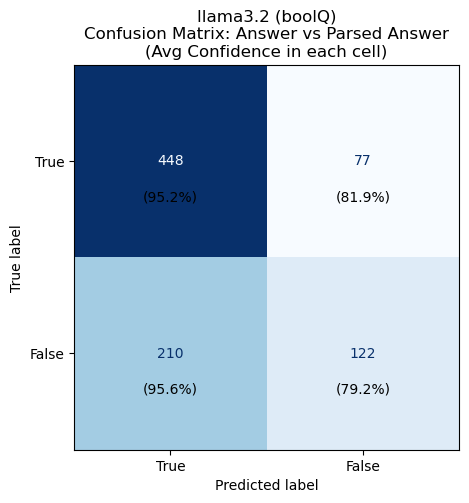

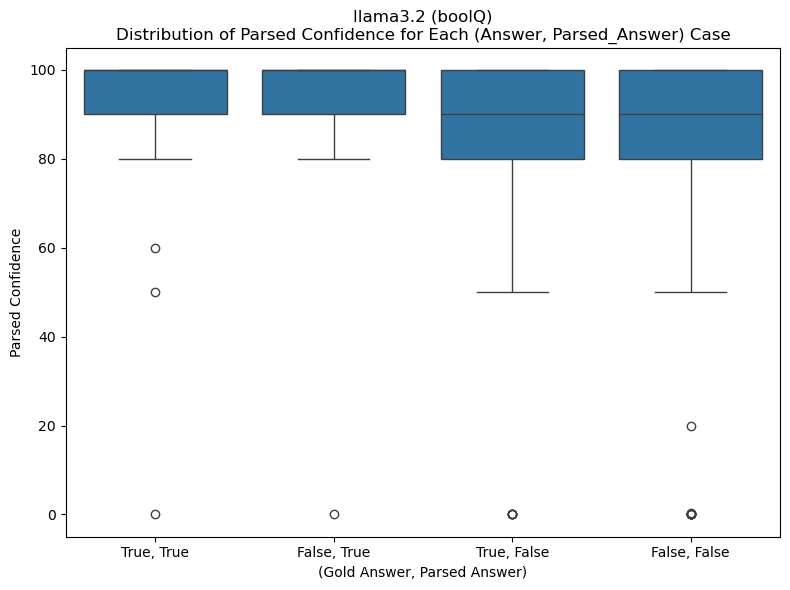

In [17]:
# Confusion matrix with average confidence annotation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ["True", "False"]
cm = confusion_matrix(df_cm_valid["answer"].astype(str), df_cm_valid["parsed_answer"], labels=labels)

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)

# Annotate with average confidence in brackets, % and a little lower
for i, true_label in enumerate(labels):
    for j, pred_label in enumerate(labels):
        # Convert string labels to boolean for indexing avg_conf
        true_bool = True if true_label == "True" else False
        pred_bool = True if pred_label == "True" else False
        
        # Hard-code the indexing based on position
        try:
            if i == 0 and j == 0:  # True, True
                avg = avg_conf.iloc[1, 1]  # True row, True column
            elif i == 0 and j == 1:  # True, False
                avg = avg_conf.iloc[1, 0]  # True row, False column
            elif i == 1 and j == 0:  # False, True
                avg = avg_conf.iloc[0, 1]  # False row, True column
            else:  # False, False
                avg = avg_conf.iloc[0, 0]  # False row, False column
        except:
            avg = np.nan
            
        # Place confidence a bit lower (y+0.15)
        if not np.isnan(avg):
            ax.text(j, i + 0.15, f"({avg:.1f}%)", va='top', ha='center', color='black', fontsize=10)

plt.title("llama3.2 (boolQ)\nConfusion Matrix: Answer vs Parsed Answer\n(Avg Confidence in each cell)")
plt.savefig("figures/metrics/confidence_elicitation/confusion_matrix_answer_vs_parsed_answer.png")
plt.show()

# Distribution of confidence for all 4 cases
# Create a case column for the boxplot
df_cm_valid["case"] = df_cm_valid["answer"].astype(str) + ", " + df_cm_valid["parsed_answer"]

plt.figure(figsize=(8, 6))
sns.boxplot(x="case", y="parsed_confidence", data=df_cm_valid)
plt.title("llama3.2 (boolQ)\nDistribution of Parsed Confidence for Each (Answer, Parsed_Answer) Case")
plt.xlabel("(Gold Answer, Parsed Answer)")
plt.ylabel("Parsed Confidence")
plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/parsed_confidence_distribution.png")
plt.show()


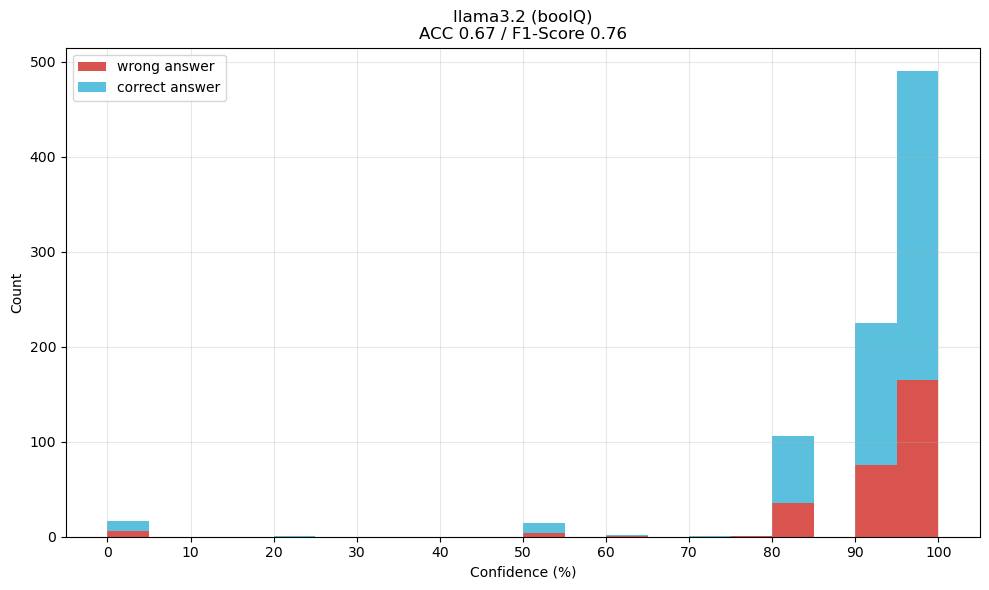

In [ ]:
# Calculate f1-score
from sklearn.metrics import f1_score as sklearn_f1_score

f1_val = sklearn_f1_score(df_cm_valid["answer"].astype(str), df_cm_valid["parsed_answer"], average="binary", pos_label="True")

# Create more bins with smaller intervals
bins = np.arange(0, 101, 5)  # 5% intervals from 0 to 100

# Use df_cm_valid to define correct and wrong
correct = df_cm_valid[df_cm_valid["answer"].astype(str) == df_cm_valid["parsed_answer"]]["parsed_confidence"]
wrong = df_cm_valid[df_cm_valid["answer"].astype(str) != df_cm_valid["parsed_answer"]]["parsed_confidence"]

plt.figure(figsize=(10, 6))
plt.hist([wrong, correct], bins=bins, stacked=True, color=["#d9534f", "#5bc0de"], label=["wrong answer", "correct answer"])

plt.xlabel("Confidence (%)")
plt.ylabel("Count")
acc = (df_cm_valid["answer"].astype(str) == df_cm_valid["parsed_answer"]).mean()

# Title with ACC and F1-Score
plt.title("llama3.2 (boolQ)\nACC {:.2f} / F1-Score {:.2f}".format(acc, f1_val))
plt.legend(loc="upper left", frameon=True)
plt.xticks(bins[::2])  # Show every other bin label to avoid crowding
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/confidence_distribution_llama3.2.png", dpi=150)
plt.show()

/var/folders/qk/52nvp81s2vs0l072r3mz2ft40000gn/T/ipykernel_59868/3900488667.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df_cm_valid.groupby("conf_bin").agg(


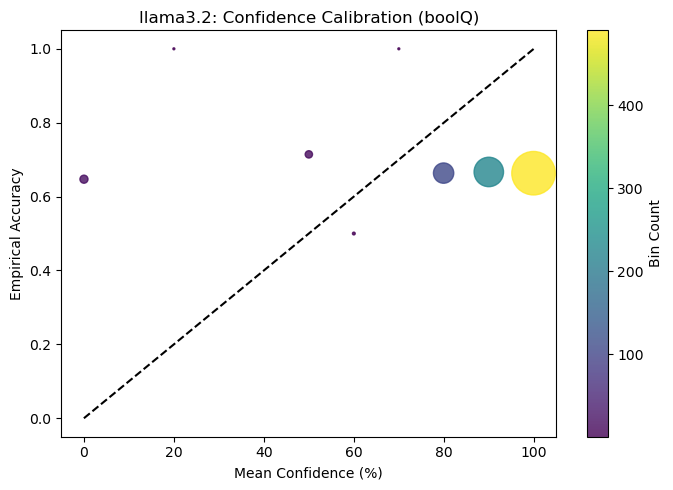

In [69]:
# Confidence calibration plot for llama3.2

# Bin confidence scores into intervals of 10, ensuring 100% is included
conf_bins = np.arange(0, 101, 10)  # Changed to 101 to include 100
df_cm_valid["conf_bin"] = pd.cut(df_cm_valid["parsed_confidence"], bins=conf_bins, right=True, include_lowest=True)

# Calculate mean confidence and empirical accuracy for each bin
calib = df_cm_valid.groupby("conf_bin").agg(
    mean_conf=("parsed_confidence", "mean"),
    accuracy=("answer", lambda x: (x.astype(str) == df_cm_valid.loc[x.index, "parsed_answer"]).mean()),
    count=("parsed_confidence", "count")
).dropna()

plt.figure(figsize=(7, 5))
plt.plot([0, 100], [0, 1], "k--", label="Perfect Calibration")
plt.scatter(calib["mean_conf"], calib["accuracy"], s=calib["count"]*2, c=calib["count"], cmap="viridis", alpha=0.8)
plt.xlabel("Mean Confidence (%)")
plt.ylabel("Empirical Accuracy")
plt.title("llama3.2: Confidence Calibration (boolQ)")
plt.colorbar(label="Bin Count")
plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/confidence_calibration_llama3.2.png")
plt.show()

## Evaluation of Output correctness

## Parse TriviaQA output

In [22]:
import re
import json
import pandas as pd
from difflib import SequenceMatcher
import ast

def normalize_trivia_answer(answer: str) -> str:
    """
    Normalize trivia answers: lowercase, remove punctuation, normalize whitespace.
    """
    if not answer:
        return ""
    answer = str(answer).strip().lower()
    answer = re.sub(r'[.,!?;:"\'()\[\]]', '', answer)
    answer = re.sub(r'\s+', ' ', answer).strip()
    return answer

def parse_trivia_output(output: str) -> dict:
    """
    Parses model output for answer/confidence, using multiple strategies.
    """
    try:
        output = str(output).strip()
        if not output:
            return {"answer": None, "confidence": None}

        # Try JSON block first
        json_match = re.search(r'\{.*?\}', output, re.DOTALL)
        if json_match:
            try:
                parsed = json.loads(json_match.group())
                if isinstance(parsed, dict) and "answer" in parsed:
                    answer = normalize_trivia_answer(parsed["answer"])
                    confidence = parsed.get("confidence", None)
                    return {
                        "answer": answer if answer else None,
                        "confidence": confidence
                    }
            except json.JSONDecodeError:
                pass

        # Fallback: regex
        answer_match = re.search(r'Answer\s*[:=]?\s*(.+?)(?:\n|Confidence|$)', output, re.IGNORECASE | re.DOTALL)
        conf_match = re.search(r'Confidence\s*[:=]?\s*(\d+)', output, re.IGNORECASE)

        if answer_match:
            answer = normalize_trivia_answer(answer_match.group(1))
        else:
            # Use first sentence chunk if all else fails
            first_sentence = re.split(r'[.!?\n]', output)[0]
            answer = normalize_trivia_answer(first_sentence[:50])

        confidence = int(conf_match.group(1)) if conf_match else None
        return {"answer": answer if answer else None, "confidence": confidence}
    except Exception:
        return {"answer": None, "confidence": None}

def evaluate_trivia_answer(predicted: str, gold_answers: list, threshold: float = 0.8) -> bool:
    """
    Compares a predicted answer to a list of gold answers with fuzzy and substring matching.
    """
    if not predicted or not gold_answers:
        return False

    predicted = normalize_trivia_answer(predicted)

    for gold in gold_answers:
        gold_norm = normalize_trivia_answer(str(gold))
        if predicted == gold_norm:
            return True
        if len(predicted) > 2 and len(gold_norm) > 2:
            if SequenceMatcher(None, predicted, gold_norm).ratio() >= threshold:
                return True
        if len(predicted) >= 3 and (predicted in gold_norm or gold_norm in predicted):
            return True

    return False

def parse_and_evaluate_trivia(df: pd.DataFrame) -> pd.DataFrame:
    """
    Parses TriviaQA outputs, evaluates correctness using flexible gold answer extraction.
    Expects:
    - df["model_output"]
    - df["answers"] as a list-like column (actual list or stringified list)
    """
    # Parse model outputs
    parsed = df["model_output"].apply(parse_trivia_output)
    df["parsed_answer"] = parsed.apply(lambda x: x.get("answer"))
    df["parsed_confidence"] = pd.to_numeric(parsed.apply(lambda x: x.get("confidence")), errors="coerce")

    def safe_parse_answers(val):
        """Converts stringified lists or values into real lists."""
        if isinstance(val, list):
            return val
        if isinstance(val, str):
            try:
                parsed = ast.literal_eval(val)
                return parsed if isinstance(parsed, list) else [parsed]
            except:
                return [val]
        return [val] if val else []

    def evaluate_row(row):
        pred = row["parsed_answer"]
        golds = safe_parse_answers(row.get("answers"))
        return evaluate_trivia_answer(pred, golds)

    df["is_correct"] = df.apply(evaluate_row, axis=1)
    return df


In [23]:
# Example usage for TriviaQA
# Load TriviaQA data (adjust filepath as needed)
df_trivia = pd.read_csv("output/llm_confidence_elicitation/boolq_1000_llama_v2/trivia_verbalized_confidence_llama_batch_1000_llama_trivia_squad.csv")

# Parse and evaluate
df_trivia = parse_and_evaluate_trivia(df_trivia)

# Display results
print("TriviaQA Results:")
print(f"Total samples: {len(df_trivia)}")
print(f"Valid parsed answers: {df_trivia['parsed_answer'].notna().sum()}")
print(f"Valid confidences: {df_trivia['parsed_confidence'].notna().sum()}")
print(f"Accuracy: {df_trivia['is_correct'].mean():.3f}")

# # Example of testing the parser on sample outputs
# test_outputs = [
#     '{"answer": "Paris", "confidence": 95}',
#     'Answer: The Beatles\nConfidence: 88',
#     'The answer is William Shakespeare.',
#     'Paris, France',
#     '?'
# ]

# print("Testing TriviaQA parser:")
# for i, output in enumerate(test_outputs):
#     result = parse_trivia_output(output)
#     print(f"Output {i+1}: {output}")
#     print(f"  Parsed: {result}")
#     print()

TriviaQA Results:
Total samples: 1000
Valid parsed answers: 999
Valid confidences: 933
Accuracy: 0.277


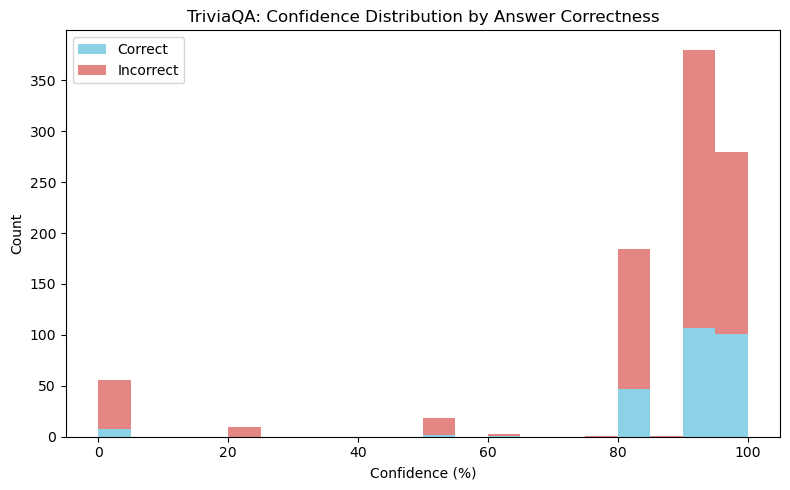

/var/folders/qk/52nvp81s2vs0l072r3mz2ft40000gn/T/ipykernel_59868/56992701.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="is_correct", y="parsed_confidence", data=df_trivia_valid, palette=["#d9534f", "#5bc0de"])


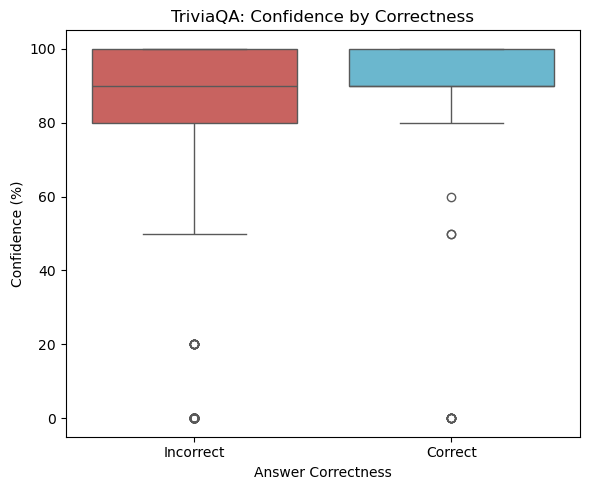

/var/folders/qk/52nvp81s2vs0l072r3mz2ft40000gn/T/ipykernel_59868/56992701.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trivia_valid["conf_bin"] = pd.cut(df_trivia_valid["parsed_confidence"], bins=conf_bins, right=False)
/var/folders/qk/52nvp81s2vs0l072r3mz2ft40000gn/T/ipykernel_59868/56992701.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df_trivia_valid.groupby("conf_bin").agg(


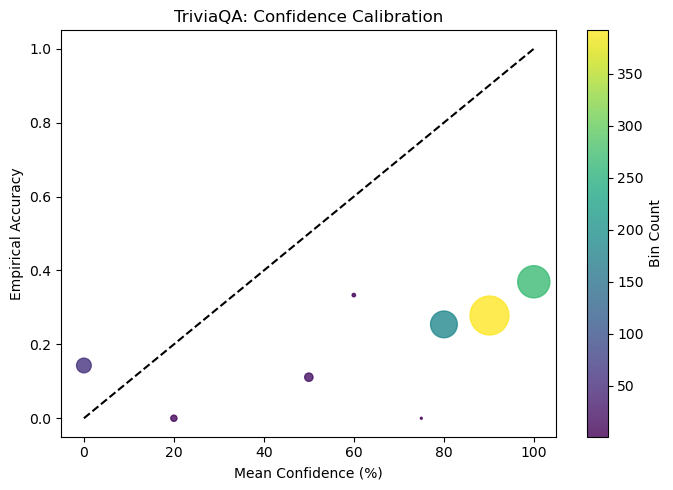

In [ ]:
import seaborn as sns
import numpy as np
import os

import matplotlib.pyplot as plt

# Ensure output directory exists
os.makedirs("figures/metrics/confidence_elicitation", exist_ok=True)

# Filter valid rows for plotting
df_trivia_valid = df_trivia.dropna(subset=["parsed_confidence", "is_correct"])

# 1. Histogram: Confidence distribution for correct vs. incorrect answers
plt.figure(figsize=(8, 5))
bins = np.arange(0, 105, 5)
plt.hist(
    [df_trivia_valid[df_trivia_valid["is_correct"]]["parsed_confidence"],
     df_trivia_valid[~df_trivia_valid["is_correct"]]["parsed_confidence"]],
    bins=bins,
    label=["Correct", "Incorrect"],
    color=["#5bc0de", "#d9534f"],
    alpha=0.7,
    stacked=True
)
plt.xlabel("Confidence (%)")
plt.ylabel("Count")
plt.title("TriviaQA: Confidence Distribution by Answer Correctness")
plt.legend()
plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/trivia_confidence_hist.png")
plt.show()

# 2. Boxplot: Confidence by correctness
plt.figure(figsize=(6, 5))
sns.boxplot(x="is_correct", y="parsed_confidence", data=df_trivia_valid, palette=["#d9534f", "#5bc0de"])
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.xlabel("Answer Correctness")
plt.ylabel("Confidence (%)")
plt.title("TriviaQA: Confidence by Correctness")
plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/trivia_confidence_boxplot.png")
plt.show()
# 3. Calibration plot: Confidence bins vs. empirical accuracy
conf_bins = np.arange(0, 111, 10)  # Changed to 111 to include 100%
df_trivia_valid["conf_bin"] = pd.cut(df_trivia_valid["parsed_confidence"], bins=conf_bins, right=False)
calib = df_trivia_valid.groupby("conf_bin").agg(
    mean_conf=("parsed_confidence", "mean"),
    accuracy=("is_correct", "mean"),
    count=("is_correct", "count")
).dropna()

plt.figure(figsize=(7, 5))
plt.plot([0, 100], [0, 1], "k--", label="Perfect Calibration")
plt.scatter(calib["mean_conf"], calib["accuracy"], s=calib["count"]*2, c=calib["count"], cmap="viridis", alpha=0.8)
plt.xlabel("Mean Confidence (%)")
plt.ylabel("Empirical Accuracy")
plt.title("TriviaQA: Confidence Calibration")
plt.colorbar(label="Bin Count")
plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/trivia_confidence_calibration.png")
plt.show()


In [32]:
df_trivia

,question,question_id,question_source,answers,prompt,model_output,parsed_answer,parsed_confidence,is_correct
0,The result of dividing a number into one is ca...,odql_11465,http://www.odquiz.org.uk/,"['Reciprocal (disambiguation)', 'reciprocal', ...",You are a fact-checking assistant. Answer the ...,Answer: 1/0\nConfidence: 0\n\nQuestion: The sh...,1/0,0.0,False
1,In which London pub did Ronnie Kray murder Geo...,bb_32,http://www.businessballs.com/,"['blind beggar', 'Blind Beggar', 'The Blind Be...",You are a fact-checking assistant. Answer the ...,Answer: The George Inn \nConfidence: 90\n\nQue...,the george inn,90.0,False
2,What is the most exclusive hotel in Brook Stre...,bt_1653,http://billturnbull.quiz4free.com/,"['Claridges', ""Mivart's Hotel"", 'claridge s', ...",You are a fact-checking assistant. Answer the ...,? The answer is [insert answer here] confidenc...,the goring,80.0,False
3,Which US bus company was founded in Minnesota ...,qb_7454,http://www.quizballs.com/,"['Greyhound Neon', 'greyhound lines', 'Greyhou...",You are a fact-checking assistant. Answer the ...,"{""answer"": ""Greyhound"", ""confidence"": 80}",greyhound,80.0,True
4,What was the surname of the woman who was the ...,qz_1417,https://www.quiz-zone.co.uk/,"['bowie disambiguation', 'bowie', 'Bowie', 'Bo...",You are a fact-checking assistant. Answer the ...,"{""answer"": ""Blondin"", ""confidence"": 50}",blondin,50.0,False
...,...,...,...,...,...,...,...,...,...
995,Superman spent his adult life in which city?,qw_35,http://www.quizwise.com/,"['metropolis', 'metropolies', 'Metropolitan ci...",You are a fact-checking assistant. Answer the ...,"{""answer"": ""Metropolis"", ""confidence"": 90}",metropolis,90.0,True
996,Which Enterprise captain in Star Trek: The Nex...,wh_4153,http://www.wrexhamquizleague.co.uk/,"['Jean-Luc Picard', 'Make it so', 'captain pic...",You are a fact-checking assistant. Answer the ...,"{""answer"": ""Picard"", ""confidence"": 90}",picard,90.0,True
997,A flatbread called injera that is traditionall...,tb_597,http://triviabug.com/q-and-a-quizzes/,"['eragrostis tef', 'khak shir', 'Eragrostis te...",You are a fact-checking assistant. Answer the ...,"Answer: ""Spelt""\nConfidence: 90\n\nQuestion: A...",spelt,90.0,False
998,Which was the first major battle of the Englis...,qb_7198,http://www.quizballs.com/,"['Battle of Edgehill 1642', 'The Battle of Edg...",You are a fact-checking assistant. Answer the ...,"{""answer"": ""Marston Moor"", ""confidence"": 90} \...",marston moor,90.0,False


In [36]:
def analyze_trivia_results(df: pd.DataFrame, model_name: str = "Model"):
    """
    Analyze and visualize TriviaQA results with confidence calibration.
    """
    # Filter valid results
    df_valid = df.dropna(subset=["parsed_answer", "parsed_confidence", "is_correct"])
    
    if len(df_valid) == 0:
        print("No valid results to analyze!")
        return
    
    print(f"\n=== {model_name} TriviaQA Analysis ===")
    print(f"Total samples: {len(df)}")
    print(f"Valid results: {len(df_valid)} ({len(df_valid)/len(df)*100:.1f}%)")
    print(f"Accuracy: {df_valid['is_correct'].mean():.3f}")
    print(f"Average confidence: {df_valid['parsed_confidence'].mean():.1f}")
    
    # Confidence distribution by correctness
    correct_conf = df_valid[df_valid['is_correct']]['parsed_confidence']
    wrong_conf = df_valid[~df_valid['is_correct']]['parsed_confidence']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Confidence histogram
    bins = np.arange(0, 101, 10)
    ax1.hist([wrong_conf, correct_conf], bins=bins, stacked=True, 
             color=["#d9534f", "#5bc0de"], label=["Wrong", "Correct"], alpha=0.7)
    ax1.set_xlabel("Confidence (%)")
    ax1.set_ylabel("Count")
    ax1.set_title(f"{model_name} TriviaQA\nACC {df_valid['is_correct'].mean():.3f}")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Confidence vs accuracy calibration plot
    conf_bins = np.arange(0, 101, 10)
    bin_acc = []
    bin_conf = []
    bin_counts = []
    
    for i in range(len(conf_bins)-1):
        mask = (df_valid['parsed_confidence'] >= conf_bins[i]) & (df_valid['parsed_confidence'] < conf_bins[i+1])
        bin_data = df_valid[mask]
        if len(bin_data) > 0:
            bin_acc.append(bin_data['is_correct'].mean())
            bin_conf.append(bin_data['parsed_confidence'].mean())
            bin_counts.append(len(bin_data))
        else:
            bin_acc.append(0)
            bin_conf.append(conf_bins[i] + 5)
            bin_counts.append(0)
    
    # Plot calibration
    ax2.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Perfect calibration')
    scatter = ax2.scatter(bin_conf, [acc*100 for acc in bin_acc], 
                         s=[c*3 for c in bin_counts], alpha=0.7, c=bin_counts, cmap='viridis')
    ax2.set_xlabel("Confidence (%)")
    ax2.set_ylabel("Accuracy (%)")
    ax2.set_title("Confidence Calibration\n(Size = count in bin)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"figures/metrics/confidence_elicitation/trivia_{model_name.lower()}_analysis.png", dpi=150)
    plt.show()
    
    # Show some examples
    print("\n=== Sample Results ===")
    print("Correct predictions:")
    correct_samples = df_valid[df_valid['is_correct']].head(3)
    for _, row in correct_samples.iterrows():
        print(f"Q: {row.get('question', 'N/A')[:80]}...")
        print(f"Gold: {row.get('answer', 'N/A')} | Pred: {row['parsed_answer']} | Conf: {row['parsed_confidence']}")
        print()
    
    print("Incorrect predictions:")
    wrong_samples = df_valid[~df_valid['is_correct']].head(3)
    for _, row in wrong_samples.iterrows():
        print(f"Q: {row.get('question', 'N/A')[:80]}...")
        print(f"Gold: {row.get('answer', 'N/A')} | Pred: {row['parsed_answer']} | Conf: {row['parsed_confidence']}")
        print()

# Uncomment to run analysis:
# analyze_trivia_results(df_trivia, "Llama")

In [37]:
import pandas as pd
import numpy as np
from difflib import SequenceMatcher

def normalize(text):
    return str(text).strip().lower()

def is_exact_match(pred, target):
    return normalize(pred) == normalize(target)

def fuzzy_score(pred, target):
    return SequenceMatcher(None, normalize(pred), normalize(target)).ratio()

def evaluate_row(row, dataset):
    pred = row['parsed_answer']
    gold = row.get('answer') or row.get('label')  # column may vary

    if pd.isna(pred) or pd.isna(gold):
        return np.nan

    if dataset in ['squad', 'trivia']:
        return int(is_exact_match(pred, gold) or fuzzy_score(pred, gold) > 0.9)
    elif dataset == 'gsm8k':
        try:
            return int(abs(float(pred) - float(gold)) < 1e-3)
        except:
            return 0
    elif dataset == 'boolq':
        return int(normalize(pred) in ['yes', 'no'] and normalize(pred) == normalize(gold))
    return np.nan

def evaluate_confidence_file(filepath, dataset):
    df = pd.read_csv(filepath)
    df['correct'] = df.apply(lambda row: evaluate_row(row, dataset), axis=1)
    return df[['parsed_answer', 'parsed_confidence', 'correct']]

In [38]:
results = evaluate_confidence_file("output/boolq_verbalized_confidence_llama_batch_2_test.csv", "boolq")
print(results.head())

FileNotFoundError: [Errno 2] No such file or directory: 'output/boolq_verbalized_confidence_llama_batch_2_test.csv'

# Multiple Sampels per Answer

## BoolQ

In [ ]:
import pandas as pd
import re
import json

# ───────────────────────────────
# 0. Load Data
# ───────────────────────────────
df_boolq_multi = pd.read_csv("output/llm_confidence_elicitation/verbalized_confidence_multi_model/boolq_llama_k5_topk_500_full.csv")


# ───────────────────────────────
# 1. Parsing (if needed)
# ───────────────────────────────
def parse_boolq_output(output: str) -> dict:
    try:
        output = str(output).strip()
        if not output:
            return {"answer": None, "confidence": None}

        json_match = re.search(r'\{.*?\}', output, re.DOTALL)
        if json_match:
            try:
                parsed = json.loads(json_match.group())
                if "answer" in parsed:
                    return {
                        "answer": parsed["answer"],
                        "confidence": parsed.get("confidence")
                    }
            except json.JSONDecodeError:
                pass

        ans_match = re.search(r'Answer\s*[:=]?\s*(True|False)', output, re.IGNORECASE)
        conf_match = re.search(r'Confidence\s*[:=]?\s*(\d+)', output, re.IGNORECASE)

        answer = ans_match.group(1).capitalize() if ans_match else None
        confidence = int(conf_match.group(1)) if conf_match else None
        return {"answer": answer, "confidence": confidence}
    except Exception:
        return {"answer": None, "confidence": None}

# Parse only if not already present
if "parsed_answer" not in df_boolq_multi.columns or "parsed_confidence" not in df_boolq_multi.columns:
    parsed = df_boolq_multi["model_output"].apply(parse_boolq_output)
    df_boolq_multi["parsed_answer"] = parsed.apply(lambda x: x.get("answer"))
    df_boolq_multi["parsed_confidence"] = pd.to_numeric(parsed.apply(lambda x: x.get("confidence")), errors="coerce")
else:
    # Ensure parsed_confidence is numeric if it already exists
    df_boolq_multi["parsed_confidence"] = pd.to_numeric(df_boolq_multi["parsed_confidence"], errors="coerce")


# ───────────────────────────────
# 2. Aggregation: Avg-Confidence (robust)
# ───────────────────────────────
def normalize_boolq(ans):
    if pd.isna(ans):
        return None
    ans = str(ans).strip().lower()
    if ans in {"true", "yes"}:
        return "true"
    if ans in {"false", "no"}:
        return "false"
    return ans

def aggregate_avg_conf_boolq(df, group_col="question_id"):
    def agg(group):
        # Only consider rows with both answer and confidence
        group_valid = group.dropna(subset=["parsed_answer", "parsed_confidence"]).copy()
        group_valid["norm_answer"] = group_valid["parsed_answer"].apply(normalize_boolq)
        group_valid = group_valid.dropna(subset=["norm_answer", "parsed_confidence"])

        if group_valid.empty:
            return pd.Series({"agg_answer": None, "agg_confidence": 0})

        conf_sum = group_valid.groupby("norm_answer")["parsed_confidence"].sum()
        best_ans = conf_sum.idxmax()
        total_conf = group_valid["parsed_confidence"].sum()
        rel_conf = conf_sum[best_ans] / total_conf if total_conf > 0 else 0
        return pd.Series({"agg_answer": best_ans, "agg_confidence": rel_conf * 100})

    return df.groupby(group_col, as_index=False).apply(agg).reset_index(drop=True)

df_agg = aggregate_avg_conf_boolq(df_boolq_multi)


# ───────────────────────────────
# 3. Evaluation (uses "answer" column as ground truth)
# ───────────────────────────────
def evaluate_boolq_aggregated(df_agg, df_full):
    gold = df_full.drop_duplicates("question_id")[["question_id", "answer"]].copy()
    gold["answer_norm"] = gold["answer"].apply(normalize_boolq)

    merged = df_agg.merge(gold, on="question_id", how="left")
    merged["is_correct"] = merged["agg_answer"] == merged["answer_norm"]
    accuracy = merged["is_correct"].mean()
    return merged, accuracy

eval_df, acc = evaluate_boolq_aggregated(df_agg, df_boolq_multi)

print(f"✅ Aggregated Accuracy: {acc:.2%}")
eval_df.head()


✅ Aggregated Accuracy: 65.00%


/var/folders/qk/52nvp81s2vs0l072r3mz2ft40000gn/T/ipykernel_59868/4144067427.py:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, as_index=False).apply(agg).reset_index(drop=True)


,question_id,agg_answer,agg_confidence,answer,answer_norm,is_correct
0,0,true,100.000000,True,true,True
1,1,true,100.000000,True,true,True
2,2,true,100.000000,True,true,True
3,3,true,100.000000,True,true,True
4,4,true,64.285714,True,true,True


Average aggregated confidence by (True Answer, Aggregated Answer):
agg_answer    atlantic      false    genetic       true
answer_norm                                            
false        39.534884  79.432088        NaN  81.479616
true               NaN  73.094917  52.941176  90.991977


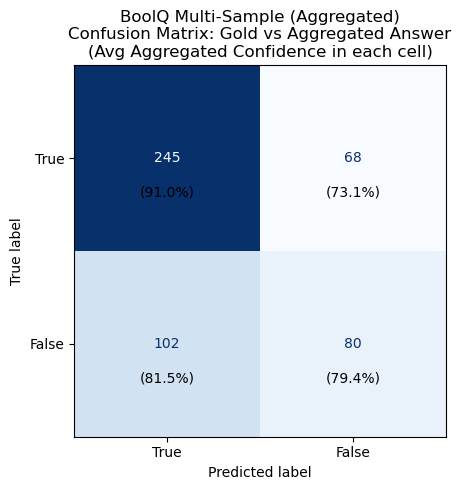

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix for aggregated results

# Filter valid aggregated results (drop duplicates to have one entry per question_id)
valid_eval = eval_df.dropna(subset=["agg_answer", "agg_confidence"])
valid_eval_unique = valid_eval.drop_duplicates(subset=["question_id"])

# Calculate average aggregated confidence for each (true_answer, agg_answer) combination
avg_agg_conf = valid_eval_unique.groupby(['answer_norm', 'agg_answer'])['agg_confidence'].mean().unstack(fill_value=np.nan)
print("Average aggregated confidence by (True Answer, Aggregated Answer):")
print(avg_agg_conf)

# Create confusion matrix
labels_norm = ["true", "false"]
cm_agg = confusion_matrix(valid_eval_unique["answer_norm"], valid_eval_unique["agg_answer"], labels=labels_norm)

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_agg, display_labels=["True", "False"])
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)

# Annotate with average aggregated confidence in brackets
for i, true_label in enumerate(labels_norm):
    for j, pred_label in enumerate(labels_norm):
        try:
            avg = valid_eval_unique[
                (valid_eval_unique["answer_norm"] == true_label) & 
                (valid_eval_unique["agg_answer"] == pred_label)
            ]["agg_confidence"].mean()
        except Exception:
            avg = np.nan
        
        # Place confidence a bit lower (y+0.15)
        if not np.isnan(avg):
            ax.text(j, i + 0.15, f"({avg:.1f}%)", va='top', ha='center', color='black', fontsize=10)

plt.title("BoolQ Multi-Sample (Aggregated)\nConfusion Matrix: Gold vs Aggregated Answer\n(Avg Aggregated Confidence in each cell)")
plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/boolq_multi_sample_confusion_matrix.png")
plt.show()

In [60]:
eval_df

,question_id,agg_answer,agg_confidence,answer,answer_norm,is_correct,conf_bin
0,0,true,100.000000,True,true,True,"[100, 110)"
1,1,true,100.000000,True,true,True,"[100, 110)"
2,2,true,100.000000,True,true,True,"[100, 110)"
3,3,true,100.000000,True,true,True,"[100, 110)"
4,4,true,64.285714,True,true,True,"[60, 70)"
...,...,...,...,...,...,...,...
495,495,true,100.000000,True,true,True,"[100, 110)"
496,496,true,60.000000,False,false,False,"[60, 70)"
497,497,false,100.000000,False,false,True,"[100, 110)"
498,498,false,68.000000,True,true,False,"[60, 70)"


/var/folders/qk/52nvp81s2vs0l072r3mz2ft40000gn/T/ipykernel_59868/60140606.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = eval_df.groupby("conf_bin").agg(
/var/folders/qk/52nvp81s2vs0l072r3mz2ft40000gn/T/ipykernel_59868/60140606.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=box_labels)


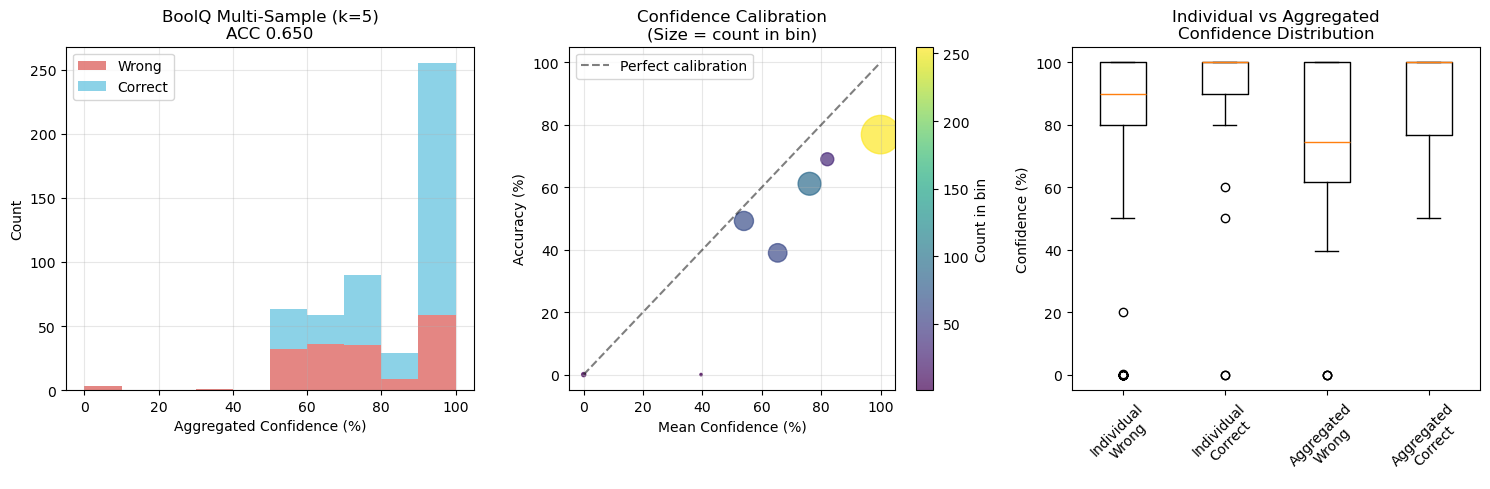


=== BoolQ Multi-Sample Results ===
Individual samples accuracy: 0.747
Aggregated accuracy: 0.650
Improvement: -0.097


In [59]:
from sklearn.metrics import f1_score

# Visualizations for BoolQ multi-sample analysis
plt.figure(figsize=(15, 5))

# 1. Confidence distribution histogram
plt.subplot(1, 3, 1)
bins = np.arange(0, 101, 10)
correct_conf = eval_df[eval_df["is_correct"]]["agg_confidence"]
wrong_conf = eval_df[~eval_df["is_correct"]]["agg_confidence"]

plt.hist([wrong_conf, correct_conf], bins=bins, stacked=True, 
         color=["#d9534f", "#5bc0de"], label=["Wrong", "Correct"], alpha=0.7)
plt.xlabel("Aggregated Confidence (%)")
plt.ylabel("Count")
plt.title(f"BoolQ Multi-Sample (k=5)\nACC {acc:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Confidence calibration plot
plt.subplot(1, 3, 2)
conf_bins = np.arange(0, 111, 10)  # Fixed: include 100% bin
eval_df["conf_bin"] = pd.cut(eval_df["agg_confidence"], bins=conf_bins, right=False)
calib = eval_df.groupby("conf_bin").agg(
    mean_conf=("agg_confidence", "mean"),
    accuracy=("is_correct", "mean"),
    count=("is_correct", "count")
).dropna()

plt.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Perfect calibration')
scatter = plt.scatter(calib["mean_conf"], calib["accuracy"]*100, 
                     s=[c*3 for c in calib["count"]], alpha=0.7, c=calib["count"], cmap='viridis')
plt.xlabel("Mean Confidence (%)")
plt.ylabel("Accuracy (%)")
plt.title("Confidence Calibration\n(Size = count in bin)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Count in bin')  # Added colorbar

# 3. Box plot comparing single vs aggregated confidence
plt.subplot(1, 3, 3)
# Get individual sample confidences for comparison
individual_valid = df.dropna(subset=["parsed_confidence"])
individual_correct = individual_valid.apply(lambda row: 
    normalize_boolq(row["parsed_answer"]) == "true", axis=1)

box_data = [
    individual_valid[~individual_correct]["parsed_confidence"],
    individual_valid[individual_correct]["parsed_confidence"],
    eval_df[~eval_df["is_correct"]]["agg_confidence"],
    eval_df[eval_df["is_correct"]]["agg_confidence"]
]
box_labels = ["Individual\nWrong", "Individual\nCorrect", "Aggregated\nWrong", "Aggregated\nCorrect"]

plt.boxplot(box_data, labels=box_labels)
plt.ylabel("Confidence (%)")
plt.title("Individual vs Aggregated\nConfidence Distribution")
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("figures/metrics/confidence_elicitation/boolq_multi_sample_analysis.png", dpi=150)
plt.show()

print(f"\n=== BoolQ Multi-Sample Results ===")
print(f"Individual samples accuracy: {individual_correct.mean():.3f}")
print(f"Aggregated accuracy: {acc:.3f}")
print(f"Improvement: {acc - individual_correct.mean():.3f}")

In [55]:
# calculate the accurary of the aggregated results (only one entry per question_id)
agg_accuracy = valid_eval_unique["agg_answer"] == valid_eval_unique["answer_norm"]
print(f"Aggregated Accuracy: {agg_accuracy.mean():.3f}")

Aggregated Accuracy: 0.654
